# Setup

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [ ]:
# If you want to  assign 2 TPU cores per process,
# for both notebook and command line
#https://docs.google.com/document/d/1sbRFVSPePq_8oGBntSOmG0V5gqxyNiuDn-4_ph8eoBc/edit#heading=h.y89aert1620u

import os 
# 2x 2 chips (4 cores) per process:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,2,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0,1" # Change to "2,3" for the second machine
# Pick a unique port per process
os.environ["TPU_MESH_CONTROLLER_ADDRESS"] = "localhost:8476"
os.environ["TPU_MESH_CONTROLLER_PORT"] = "8476"

print('done')

In [10]:
# https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython/43118091#43118091
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import einops
import matplotlib
from functools import partial
from collections import namedtuple
import jax
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, grad, jit
import jax.debug
import itertools
from itertools import repeat
from time import time

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

2022-09-30 00:44:29.870954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-30 00:44:29.906407: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 00:44:30.565127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-30 00:44:30.565272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


# Dask

In [5]:

# https://docs.dask.org/en/stable/deploying-python.html

import jax
import os
import dask
from dask.distributed import Client, LocalCluster

cpu_device, *_ = jax.devices("cpu")
cpu_count = os.cpu_count()
print('cpu count = ', cpu_count)
#client = Client(n_workers=cpu_count-1) #  start local workers as processes
#client = Client(n_workers=cpu_count-1, processes=False)  # start local workers as threads

cluster = LocalCluster(n_workers=cpu_count-1)
client = Client(cluster)

print(cluster.dashboard_link)
client




cpu count =  96


2022-09-30 00:45:14,300 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-iwdq8azb', purging
2022-09-30 00:45:14,301 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3fqig18v', purging
2022-09-30 00:45:14,301 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-8y6ublwi', purging
2022-09-30 00:45:14,302 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tioso8mf', purging
2022-09-30 00:45:14,302 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-donxubxb', purging
2022-09-30 00:45:14,302 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-bocu64to', purging
2022-09-30 00:45:14,303 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-i5ras9st', purging

http://127.0.0.1:8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 95
Total threads: 190,Total memory: 334.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46447,Workers: 95
Dashboard: http://127.0.0.1:8787/status,Total threads: 190
Started: Just now,Total memory: 334.56 GiB
Comm: tcp://127.0.0.1:34331,Total threads: 2
Dashboard: http://127.0.0.1:40381/status,Memory: 3.52 GiB
Nanny: tcp://127.0.0.1:46325,


In [6]:
# https://docs.dask.org/en/stable/futures.html
# https://examples.dask.org/applications/embarrassingly-parallel.html

def parallel_map(f, args):
    #args = jax.device_put(args, cpu_device)
    init_time = time()
    res_lazy = client.map(f, args)
    out = client.gather(res_lazy)
    end_time = time()
    return out, end_time - init_time


def serial_map(f, args):   
    init_time = time()
    out = [f(a) for a in args]
    end_time = time()
    return out, end_time - init_time

In [7]:
def f(arg):
    return f2(arg[0], arg[1], arg[2])

@partial(jit, static_argnames=["N"])
def f2(seed, x, N):
    key = jr.PRNGKey(seed)
    mat = jr.normal(key, (N, N))
    w, v = jnp.linalg.eigh(mat * jnp.transpose(mat) * x)
    return w[0]


def make_arg_combo(*args):
    iter = itertools.product(*args)
    combo = list(iter)
    #return jnp.array(combo) # one row per combo
    return combo


seeds = np.array([1, 2])   
xs = np.arange(0, 5) 
N = np.array([200]) # must be np not jnp so static_argnames=N works 
args = make_arg_combo(seeds, xs, N)

print(len(args))
print(args)

out_serial, time_serial = serial_map(f, args)
print(out_serial)
out_parallel, time_parallel = parallel_map(f, args)
assert jnp.allclose(jnp.array(out_serial), jnp.array(out_parallel))

print('DASK time serial', time_serial, ' parallel ', time_parallel)

10
[(1, 0, 200), (1, 1, 200), (1, 2, 200), (1, 3, 200), (1, 4, 200), (2, 0, 200), (2, 1, 200), (2, 2, 200), (2, 3, 200), (2, 4, 200)]
[DeviceArray(0., dtype=float32), DeviceArray(-27.833109, dtype=float32), DeviceArray(-55.666218, dtype=float32), DeviceArray(-83.49933, dtype=float32), DeviceArray(-111.332436, dtype=float32), DeviceArray(0., dtype=float32), DeviceArray(-27.186575, dtype=float32), DeviceArray(-54.37315, dtype=float32), DeviceArray(-81.5597, dtype=float32), DeviceArray(-108.7463, dtype=float32)]


DASK time serial 0.3217322826385498  parallel  2.4136104583740234


# Image embedding

# Scaling laws

In [13]:
# Scaling laws
rep_list = [10, 50, 100, 200]
problem_size_list = [100, 200, 500, 1000]

nreps = len(rep_list)
nsizes = len(problem_size_list)
times_serial = np.zeros((nreps, nsizes))
times_parallel = np.zeros((nreps, nsizes))

for i, nrep in enumerate(rep_list):
    seeds = np.array([1, 2, 3]) 
    xs = np.arange(1, nrep+1) 
    for j, problem_size in enumerate(problem_size_list):
        N = np.array([problem_size])
        args = make_arg_combo(seeds, xs, N)
  
        out_serial, time_serial = serial_map(f, args)
        out_parallel, time_parallel = parallel_map(f, args)
        assert jnp.allclose(jnp.array(out_serial), jnp.array(out_parallel), atol=1e-3)
        print('nrep {}, size {}, time parallel {}, serial {}'.format(
                nrep, problem_size, time_parallel,  time_serial))
        times_serial[i,j] = time_serial
        times_parallel[i,j] = time_parallel


nrep 10, size 100, time parallel 1.4949214458465576, serial 0.471757173538208


nrep 10, size 200, time parallel 1.5646946430206299, serial 0.005398750305175781


nrep 10, size 500, time parallel 1.4116625785827637, serial 7.293564796447754
nrep 10, size 1000, time parallel 0.6239273548126221, serial 20.874870538711548
nrep 50, size 100, time parallel 0.8497593402862549, serial 0.10019874572753906
nrep 50, size 200, time parallel 1.0943667888641357, serial 0.36998677253723145
nrep 50, size 500, time parallel 0.8663961887359619, serial 1.9791676998138428
nrep 50, size 1000, time parallel 1.7292506694793701, serial 9.440464496612549
nrep 100, size 100, time parallel 0.5596907138824463, serial 0.2266066074371338
nrep 100, size 200, time parallel 0.569159746170044, serial 0.830474853515625
nrep 100, size 500, time parallel 1.469144582748413, serial 4.492912530899048
nrep 100, size 1000, time parallel 2.3955020904541016, serial 21.439135313034058
nrep 200, size 100, time parallel 0.7447218894958496, serial 0.4780540466308594
nrep 200, size 200, time parallel 1.4815454483032227, serial 1.7552564144134521
nrep 200, size 500, time parallel 1.61350083351

In [15]:
0.6*1e-6

6e-07

In [ ]:
print(out_serial)
print(out_parallel)
print(jnp.allclose(jnp.array(out_serial), jnp.array(out_parallel), atol=1e-3))

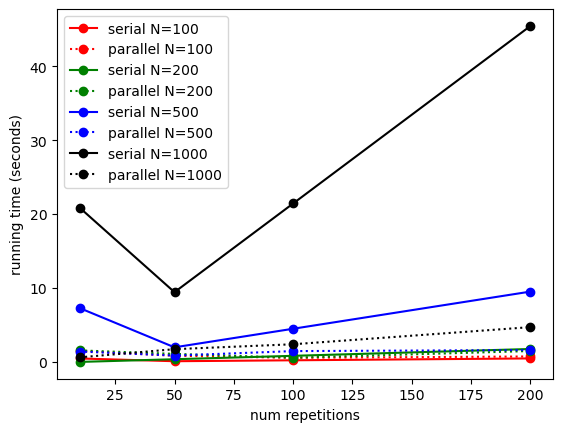

In [14]:
plt.figure()
colors = ['r', 'g', 'b', 'k', 'y']
for j, problem_size in enumerate(problem_size_list):
    plt.plot(rep_list, times_serial[:,j], linestyle = '-', marker = 'o', 
            color=colors[j], label=f'serial N={problem_size}')
    plt.plot(rep_list, times_parallel[:,j], linestyle = ':', marker = 'o', 
            color=colors[j], label=f'parallel N={problem_size}')
plt.xlabel('num repetitions')
plt.ylabel('running time (seconds)')
#plt.yscale('log')
plt.legend()

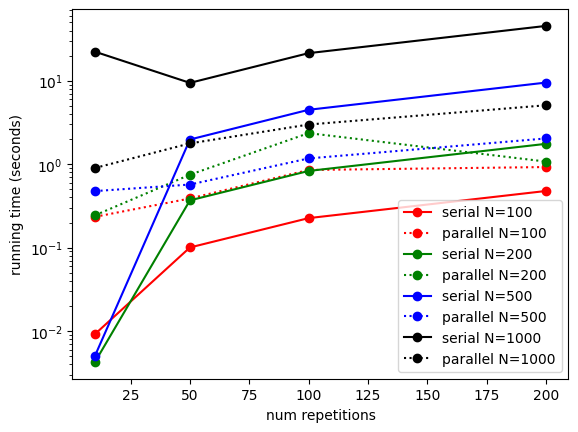

In [45]:
plt.figure()
colors = ['r', 'g', 'b', 'k', 'y']
for j, problem_size in enumerate(problem_size_list):
    plt.plot(rep_list, times_serial[:,j], linestyle = '-', marker = 'o', 
            color=colors[j], label=f'serial N={problem_size}')
    plt.plot(rep_list, times_parallel[:,j], linestyle = ':', marker = 'o', 
            color=colors[j], label=f'parallel N={problem_size}')
plt.xlabel('num repetitions')
plt.ylabel('running time (seconds)')
plt.yscale('log')
plt.legend()